In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from os import path
from tec_reduced_model.set_parameters import (
    set_thermal_parameters,
    set_experiment_parameters,
    set_ambient_temperature,
)
from tec_reduced_model.process_experimental_data import import_thermal_data, get_idxs
from __future__ import print_function
import dfols

plt.style.use(['science','vibrant'])

plt.rcParams.update({
    "font.family": "sans-serif",
    "text.usetex": False,
    "font.size": 8,
    "axes.labelsize": 10,
})

In [2]:
# Change simulation parameters here
temperature = 25  # in degC, valid values: 0, 10, 25
Crate = 1         # valid values: 0.5, 1, 2
cells_ignore = ["789","790","791"]    # cells to ignore, in this case we ignore cell 791 because the data for that cell is faulty

In [3]:
# Define the TSPMe model
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

dataset = import_thermal_data(Crate, temperature)
data_conc = {"time": [], "voltage": [], "temperature": []}

for cell, data in dataset.items():
    if cell in cells_ignore:
        continue

    idx_start, idx_end = get_idxs(data, Crate * 5, 5 / 3)
    if len(idx_end) == 1:
        idx_end = np.append(idx_end, len(data["Time [s]"]))

    data_conc["time"] = np.append(
        data_conc["time"],
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
    )
    data_conc["voltage"] = np.append(
        data_conc["voltage"], data["Voltage [V]"][idx_start[0] : idx_end[1]]
    )
    data_conc["temperature"] = np.append(
        data_conc["temperature"],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
    )

In [4]:
def R_squared(solution, x_data, y_data):
    y_bar = np.mean(y_data)
    SS_tot = np.sum((y_data - y_bar) ** 2)
    res = y_data - solution(x_data)
    res = res[~np.isnan(res)]  # remove NaNs due to extrapolation
    SS_res = np.sum(res ** 2)
    n=len(y_data)

    return  1 - SS_res/n #/ SS_tot

In [5]:
def mse(x):
    # Define parameter set Chen 2020 (see PyBaMM documentation for details)
    # This is the reference parameter set, which we then update for the adjusted thermal parameters
    param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

    # We now update the parameter set for the adjusted parameters
    param = set_thermal_parameters(param, 16, 2.32e6, temperature)
    param = set_experiment_parameters(param, Crate, temperature)
    param = set_ambient_temperature(param, Crate, temperature)
    param["Negative electrode diffusivity [m2.s-1]"] = x[0]

    # Define the experiment to be a CC discharge at the defined C-rate followed by a 2-hour relaxation
    experiment = pybamm.Experiment(
        [
            "Discharge at {}C until 2.5 V (5 seconds period)".format(Crate),
            "Rest for 2 hours",
        ],
        period="30 seconds",
    )

    # Solve the model
    simulation = pybamm.Simulation(
        model,
        parameter_values=param,
        experiment=experiment,
    )
    simulation.solve()
    solution = simulation.solution
    R_squared(solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"])
    #sol_sq= solution["Terminal voltage [V]"].entries
    #exp_sq= data_conc["voltage"]
    
    return np.array(1-R_squared(solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"]))     #(np.abs(sol_sq-exp_sq))

In [6]:
from scipy import optimize
x0 =np.array([2e-14])
minimum = optimize.fmin(mse, x0, xtol=0.0000000001, ftol=0.0000000001)

Optimization terminated successfully.
         Current function value: 0.001964
         Iterations: 11
         Function evaluations: 22


In [7]:
# Define the TSPMe model
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

# Define parameter set Chen 2020 (see PyBaMM documentation for details)
# This is the reference parameter set, which we then update for the adjusted thermal parameters
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

# We now update the parameter set for the adjusted parameters
param = set_thermal_parameters(param, 16, 2.32e6, temperature)
param = set_experiment_parameters(param, Crate, temperature)
param = set_ambient_temperature(param, Crate, temperature)
param["Negative electrode diffusivity [m2.s-1]"] = minimum[0]

# Define the experiment to be a CC discharge at the defined C-rate followed by a 2-hour relaxation
experiment = pybamm.Experiment(
    [
        "Discharge at {}C until 2.5 V (5 seconds period)".format(Crate),
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

# Solve the model
simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)
simulation.solve()
solution = simulation.solution


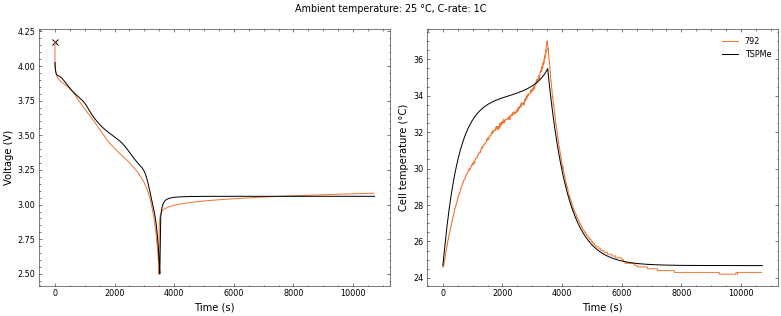

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
dataset = import_thermal_data(Crate, temperature)
data_conc = {"time": [], "voltage": [], "temperature": []}

for cell, data in dataset.items():
    if cell in cells_ignore:
        continue

    idx_start, idx_end = get_idxs(data, Crate * 5, 5 / 3)
    if len(idx_end) == 1:
        idx_end = np.append(idx_end, len(data["Time [s]"]))

    axes[0].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Voltage [V]"][idx_start[0] : idx_end[1]],
        label=cell,
    )
    axes[1].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
        label=cell,
    )

    data_conc["time"] = np.append(
        data_conc["time"],
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
    )
    data_conc["voltage"] = np.append(
        data_conc["voltage"], data["Voltage [V]"][idx_start[0] : idx_end[1]]
    )
    data_conc["temperature"] = np.append(
        data_conc["temperature"],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
    )

    
axes[0].plot(
    solution["Time [s]"].entries,
    solution["Terminal voltage [V]"].entries,
    color="black",
    label="TSPMe",
)

axes[0].scatter(
    0,
    solution["X-averaged battery open circuit voltage [V]"].entries[0],
    marker="x",
    color="black",
)

axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Voltage (V)")

axes[1].plot(
    solution["Time [s]"].entries,
    solution["X-averaged cell temperature [K]"].entries - 273.15,
    color="black",
    label="TSPMe",
)

axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Cell temperature (°C)")
axes[1].legend()
    
fig.suptitle("Ambient temperature: {} °C, C-rate: {}C".format(temperature, Crate))    

fig.tight_layout()
fig.subplots_adjust(top=0.9)

In [9]:
def rmse(solution, x_data, y_data):
    error = solution(x_data) - y_data
    error = error[~np.isnan(error)]  # remove NaNs due to extrapolation
    return np.sqrt(np.mean(error ** 2))

error = {}
error["RMSE_V"] = rmse(
    solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"]
)
error["Rsq_V"] = R_squared(
    solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"]
)
error["RMSE_T"] = rmse(
    solution["X-averaged cell temperature [K]"],
    data_conc["time"],
    data_conc["temperature"] + 273.15,
)
error["Rsq_T"] = R_squared(
    solution["X-averaged cell temperature [K]"],
    data_conc["time"],
    data_conc["temperature"] + 273.15,
)

print("Voltage RMSE: {:.2f} mV".format(error["RMSE_V"] * 1000))
print("Voltage R^2: {:.4f}".format(error["Rsq_V"]))
print("Temperature RMSE: {:.2f} °C".format(error["RMSE_T"]))
print("Temperature R^2: {:.4f}".format(error["Rsq_T"]))

Voltage RMSE: 44.32 mV
Voltage R^2: 0.9980
Temperature RMSE: 0.96 °C
Temperature R^2: 0.0833


In [10]:
minimum[0]

2.02939453125e-14